## Домашнее задание 1. Анализ обращений в поддержку

Представьте, что вы NLP-инженер крупной фирмы, зарабатывающей на продаже и доставке своих продуктов клиентам. Как у любой хорошей фирмы, у вас есть служба поддержки, в которую клиенты регулярно обращаются с разного вида вопросами. Так как фирма крупная и клиентов много, то и обращений тоже поступает немало. Поэтому, для того, чтобы улучшить качество предоставляемого сервиса, фирма просит вас объединить поступающие обращения в группы по похожести. Из этих групп можно будет понять, на что в основном жалуются клиенты и какие части сервиса нужно улучшить.

В этом задании вам предстоит:

1. Обработать данные, очистив их от лишних слов и символов.
2. Обучить эмбеддинги слов с помощью Word2Vec.
3. Векторизовать и кластеризовать все обращения, подобрав лучшие параметры кластеризации.
4. Визуализировать полученные кластеры обращений.

In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import re

In [3]:
data = pd.read_csv(r'C:\Users\Admin\Downloads\NLP karpov\1 урок\customer_support.csv')
data

,text
0,question about cancelling order {{Order Number}}
1,i have a question about cancelling oorder {{Or...
2,i need help cancelling puchase {{Order Number}}
3,I need to cancel purchase {{Order Number}}
4,"I cannot afford this order, cancel purchase {{..."
...,...
26702,I am waiting for a rebate of {{Refund Amount}}...
26703,how to see if there is anything wrong with my ...
26704,I'm waiting for a reimbjrsement of {{Currency ...
26705,I don't know what to do to see my reimbursemen...


## Предобработка данных

Можно заметить, что в данных вся личная информация о пользователях заменена на специальные ключевые слова: `{{Order Number}}`, `{{Account Category}` и т.д. Эти строки не содержат в себе полезной информации и даже могут помешать кластеризации – тексты будут объединяться в группы по наличию таких фраз. Поэтому давайте их удалим.


Проще всего это можно сделать с помощью _регулярных выражений_.

__Регулярные выражения__ или regular expressions (__regex__) — это инструмент для поиска и манипулирования текстом на основе
шаблонов. С помощью них можно найти определенные шаблоны в строках, заменить подстроку, соответствующую шаблону, другой строкой и еще много чего. Для написания шаблонов используются специальные символы. Например,   
`.`: соответствует любому одиночному символу.   
`*`: соответствует 0 или более вхождений предыдущего элемента.   
`?`: соответствует 0 или 1 вхождению предыдущего элемента.   

Полный список специальных символов можно найти в [официальной документации](https://docs.python.org/3/library/re.html), но нам хватит и этих.

Символы `*`, и `?` работают в жадном режиме – они соответствуют __как можно большему__ количеству текста. Иногда такое поведение нежелательно. Например, шаблон `"<.*>"` соответствует всей строке `"<a> b <c>"`, а не только `"<a>"`. Добавление `?` после `*`, превратит этот символ в нежадный и он будет соответствовать __минимальному__ числу символов. То есть шаблон `"<.*?>"` будет соответствовать отдельно `"<a>"` и `"<c>"`.

```
import re
re.sub(pattern=r'<.*>', repl='replace_this', string='<a> b <c>')
>>> 'replace_this'

re.sub(pattern=r'<.*?>', repl='replace_this', string='<a> b <c>')
>>> 'replace_this b replace_this'
```

__Задание 1.__ Напишите функцию `remove_private_data`, которая принимает на вход список текстов `texts` и возвращает тексты с удаленными вхождениями подстрок, начинающихся на `{{` и заканчивающихся `}}`. В своем решении используйте регулярные выражения.

In [4]:
import re

In [5]:

def remove_private_data(texts):
    new_texts = []
    for text in texts:
        new_texts.append(re.sub(r'{{.*?}}', '', text))
    return new_texts

In [6]:
texts = remove_private_data(data.text)
texts[:5]

['question about cancelling order ',
 'i have a question about cancelling oorder ',
 'i need help cancelling puchase ',
 'I need to cancel purchase ',
 'I cannot afford this order, cancel purchase ']

Введем функцию `vocab_size`. Она принимает список текстов и возвращает число уникальных слов в нем.

In [7]:
def vocab_size(texts):
    vocab = set()
    for text in texts:
        if isinstance(text, list):
            vocab |= set(text)
        else:
            vocab |= set(text.split())

    return len(vocab)

In [8]:
vocab_size(texts)

3160

В этом домашнем задании мы будем использовать Word2Vec для работы с текстом. Он, как и дригие простые методы, работает хорошо, когда уникальных слов в словаре не очень много. Поэтому в процессе очистки текстов мы обычно стремимся уменьшить размер словаря. Для этого воспользуемся рядом стандартных способов:
1. Удалим всю пунктуацию и числа
1. Приведем текст к нижнему регистру
1. Поделим тексты на слова по пробелам и _лемматизируем_ каждое слово
1. Удалим все стоп-слова
1. Исправим опечатки в словах
1. Удалим слишком редкие слова

Пойдем по порядку.

__Задание 2.__ Напишите функцию `remove_nonalpha`, которая принимает список текстов `texts` и возвращает тексты, очищенные от __пунктуации__ и __чисел__. Набор всех символов пунктуации можно взять из `string.punctuation`. Реализация через регулярные выражения будет работать намного быстрее почти всех других способов, поэтому снова используйте их. 

Вам пригодятся квадратные скобки `[]`, которые используются, для того, чтобы обозначить множество символов в шаблоне. Например, под шаблон `"[abc]"` подойдут все 3 буквы `'a'`, `'b'` и `'c'` и ничего больше.    
Некоторые символы пунктуации (те же скобочки) зарезервированы в regex как специальные символы, поэтому перед ними надо ставить два обратных слэша `\\`, или применить `re.escape`, который проставит все автоматически.
```
re.escape("a.?b[")
>>> "a\\.\\?b\\["
```

Если вы найдете более простой способ, который вам больше нравится, то используйте его.

In [9]:
import string
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
def remove_nonalpha(texts):
    clean_texts = []
    for text in texts:
        a = re.sub(f"[{re.escape(string.punctuation)}]", '', text)
        a = re.sub(r'[0-9]', '', a)
        clean_texts.append(a)
    
    return clean_texts

In [11]:
texts = remove_nonalpha(texts)
texts[:5]

['question about cancelling order ',
 'i have a question about cancelling oorder ',
 'i need help cancelling puchase ',
 'I need to cancel purchase ',
 'I cannot afford this order cancel purchase ']

In [12]:
vocab_size(texts)

2824

Удалось неплохо уменьшить размер словаря! Двигаемся дальше.

__Задание 3.__ Напишите функцию `lemmatize_corpus`, которая принимает на вход список текстов `texts`, разбивает каждый текст на слова и лемматизирует каждое из них и приводит к __нижнему регистру__. Функция возвращает список списков слов. Для лемматизации используйте `nltk.stem.WordNetLemmatizer`.

In [13]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
from nltk.stem import WordNetLemmatizer as wnl

In [15]:
def lemmatize_corpus(texts):
    lemmatizer = wnl()
    clean_texts = []
    for text in texts:
        clean_texts.append([lemmatizer.lemmatize(word.lower()) for word in text.split()])

    return clean_texts

In [16]:
texts = lemmatize_corpus(texts)
texts[:5]

[['question', 'about', 'cancelling', 'order'],
 ['i', 'have', 'a', 'question', 'about', 'cancelling', 'oorder'],
 ['i', 'need', 'help', 'cancelling', 'puchase'],
 ['i', 'need', 'to', 'cancel', 'purchase'],
 ['i', 'cannot', 'afford', 'this', 'order', 'cancel', 'purchase']]

In [17]:
vocab_size(texts)

2763

Заметим, что в почти в каждом тексте встречаются местоимения, предлоги, союзы и т.д., которые не несут в себе никакого смысла, но при этом увеличивают длину каждого предложения. Такие слова называются стоп-словами и будет очень разумно удалить их из корпуса. Для получения набора стоп-слов объединим слова из `nltk.corpus.stopwords` и `gensim.parsing.preprocessing.STOPWORDS`.

__Задание 4.__ Напишите функцию `remove_stopwords`, которая принимает на вход список текстов `texts` из предыдущего задания и набор стоп-слов `stopwords` и удаляет стоп-слова из каждого текста. Функция возвращает очищенный список списков слов.

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [19]:
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import STOPWORDS

stopwords = STOPWORDS | set(stopwords.words('english'))
len(stopwords)

409

In [20]:
print(["a", "b"].remove("a"))

None


In [21]:
def remove_stopwords(texts, stopwords):
    clean_texts = []
    for text in texts:
        clean_texts.append([word for word in text if word not in stopwords])
    return clean_texts

In [22]:
texts = remove_stopwords(texts, stopwords)
texts[:5]

[['question', 'cancelling', 'order'],
 ['question', 'cancelling', 'oorder'],
 ['need', 'help', 'cancelling', 'puchase'],
 ['need', 'cancel', 'purchase'],
 ['afford', 'order', 'cancel', 'purchase']]

In [23]:
vocab_size(texts)

2650

Отлично, мы удалили еще около 100 уникальных слов и каждый текст стал заметно короче! Перейдем к следующей проблеме корпуса.

__ДОПОЛНИТЕЛЬНОЕ ЗАДАНИЕ (НЕ ВХОДИТ В ОЦЕНИВАНИЕ)__


Если посмотреть внимательно на тексты, то можно заметить, что многие слова содержат опечатки. Обычно, от опечаток не избавляются, потому что слов с опечатками гораздо меньше, чем правильных слов. Однако, в нашей задаче каждая опечатка может сильно повлиять на предсказание модели, так как модель не способна выучить представление для такого слова из-за малой встречаемости. В этом датасете больше __трети__ текстов содержат опечатки! Можете проверить это сами. К тому же слова с опечатками значительно увеличивают размер словаря, что ведет к большим расходам по памяти. Соответственно, попробуем исправить все опечатки.    
Самый простой способ для исправления опечаток звучит так. Возьмем множество всех английских слов и будем менять каждое слово в корпусе на ближайшее к нему английское слово. Тогда если слово не содержит опечаток, оно не поменяется, а если содержит, то опечатка должна исправиться. Осталось договориться, как считать расстояние. Для нашей цели отлично подойдет [расстояние Левенштейна](https://ru.wikipedia.org/wiki/Расстояние_Левенштейна), оно же редакторское расстояние. Расстояние Левенштейна считается как число минимальное операций удаления, добавления и замены символа, необходимое для превращения одного слова в другое. Например, для слов "арбуз" и "руза" расстояние Левенштейна равно 3. Расстояние можно импортировать из `nltk.metrics.distance`.

Множество всех слов возьмем из `nltk.corpus.words`. Конечно, совсем все слова там не содержатся, но этого списка нам вполне хватит.

In [23]:
# import nltk
# nltk.download('words')

In [24]:
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [25]:
from multiprocessing import Pool
from nltk.metrics.distance import edit_distance
from nltk.corpus import words

all_words = words.words()
len(all_words)

236736

__Задание 5.__ Напишите функцию `fix_typos`, которая принимает на вход список списков слов `texts`. Для каждого слова функция исправляет опечатки описанным выше способом и возвращает очищенные тексты. Множество всех слов `all_words` является глобальной переменной.

__Важно!__ Подсчет расстояния – это долгая операция, поэтому постарайтесь оптимизировать код. В частности
* Если слово есть среди `all_words`, то исправлять его не нужно.
* Можно не перебирать все слова из `all_words`, а взять только те, которые начинаются (или заканчиваются) на ту же букву или только те, которые имеют примерно ту же длину (можно все вместе).
* Можно использовать многопоточность, чтобы обрабатывать тексты параллельно.

```
from multiprocess import Pool

def f(x):
    return x + 1

with Pool(processes=4) as pool:
    result = list(pool.imap(f, np.arange(5)))
result
>>> [1, 2, 3, 4, 5]

```

Если вы все сделали правильно, то весь корпус должен обрабатываться не дольше 15 минут в google colab.

In [26]:
import numpy as np

In [29]:
edit_distance('rain', 'sain')

1

In [27]:
def preprocess(words):
    fixed_words = []
    for word in words:
        if word in all_words:
            fixed_words.append(word)
        else:
            result = [
                (edit_distance(word, w), w)
                for w in all_words
                if w[0] == word[0] and w[-1] == word[-1] and abs(len(w) - len(word)) < 3
            ]
            if len(result) == 0:
                continue
            distances, words = zip(*result)
            fixed_words.append(words[np.argmin(distances)])

    return fixed_words


def fix_typos(texts):
    return [preprocess(text) for text in texts]

In [31]:
texts = fix_typos(tqdm(texts))
texts[:5]

  0%|          | 0/26707 [00:00<?, ?it/s]

[['question', 'canalling', 'order'],
 ['question', 'canalling', 'order'],
 ['need', 'help', 'canalling', 'purchase'],
 ['need', 'cancel', 'purchase'],
 ['afford', 'order', 'cancel', 'purchase']]

In [28]:
vocab_size(texts)

1550

Число уникальных слов уменьшилось аж на 1000!   
Заметьте, что так как в словаре nltk присутствуют далеко не все английские слова, часть правильный слов тоже поменялась. Например, `download -> downfold` и `canceling -> cageling`. Однако, это не страшно, потому что для Word2Vec не важно, как пишется слово. Главное, чтобы все слова с одинаковым написанием имели одинаковый смысл. Так как, вероятно, `downfold` и `cageling` в оригинальном датасете вообще не встречались, то мы просто заменили одно написание другим.

__КОНЕЦ ДОПОЛНИТЕЛЬНОГО ЗАДАНИЯ__

In [28]:
# Если вы пропустили это задание, то загрузите
# обработанный корпус текстов из step5.txt.
texts = []
with open('step5.txt') as f:
    for line in f:
        texts.append(line.strip().split())

У нас остался последний шаг очистки данных – удаление редких слов.

__Задание 6.__ Напишите функцию `remove_rare_words`, которая принимает на вход все тот же список текстов `texts` и удаляет все слова, которые встретились меньше, чем в 4 текстах.

In [32]:
from collections import defaultdict

def remove_rare_words(texts):
    word_count = defaultdict(int)  # Словарь для подсчета количества текстов, в которых встречается каждое слово
    unique_words_in_texts = []  # Список для хранения уникальных слов в каждом тексте

    # Подсчитываем количество текстов, в которых встречается каждое слово
    for text in texts:
        unique_words = set(text)  # Если текст — это список, просто берем уникальные слова
        for word in unique_words:
            word_count[word] += 1
    
    # Формируем чистые тексты, удаляя редкие слова
    clean_texts = []
    for text in texts:
        clean_text = [word for word in text if word_count[word] >= 4]  # Оставляем только те слова, которые встречаются в 4 или более текстах
        clean_texts.append(clean_text)  # Собираем текст обратно как список слов

    return clean_texts


In [35]:
texts = remove_rare_words(texts)
texts[:5]

[['question', 'canalling', 'order'],
 ['question', 'canalling', 'order'],
 ['need', 'help', 'canalling', 'purchase'],
 ['need', 'cancel', 'purchase'],
 ['afford', 'order', 'cancel', 'purchase']]

In [36]:
vocab_size(texts)

530

Мы снизили число уникальных слов еще на 1000! В результате из изначального набора осталось всего около 500 слов, которые насут в себе всю наиболее важную информацию. Самое время переходить непосредственно к анализу текстов. Но перед этим посмотрим на распределение длин полученных текстов.

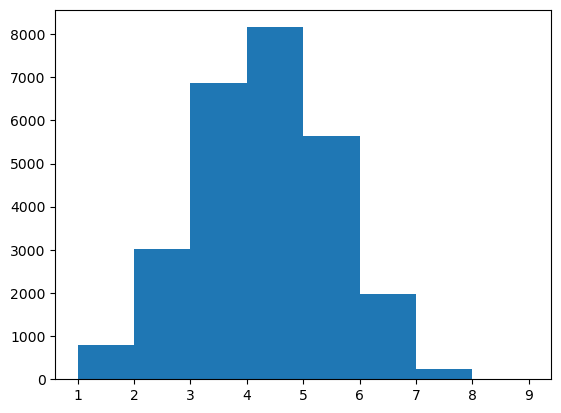

In [37]:
lens = [len(text) for text in texts]
plt.hist(lens, bins=8);

## Обучение Word2Vec

Чтобы кластеризовывать тексты, необходимо привести их к векторному виду. Для этого можно использовать BoW или TF-IDF, однако их проблема в том, что они не смогут учитывать синонимы. Так как тексты довольно короткие (в среднем 4 слова), мы можем векторизовать их, усреднив эмбеддинги слов. Осталось получить эмбеддинги, учитывающие сининимы. Для этого обучим Word2Vec.

__Задание 7.__ Напишите функцию `train_w2v`, принимающую корпус текстов и обучающую `Word2Vec` из `gensim.models` на этом корпусе. Функция возвращает обученную модель (`Word2Vec().wv`). Размер вектора выберите равным 100, а размер окна – 3. Аргумент `min_count` поставьте в 0, по умолчанию он равен 5.

In [38]:
from gensim.models import Word2Vec

def train_w2v(texts):
    model = Word2Vec(sentences=texts, vector_size=100, window=3, min_count=0, sg=0)
    return model.wv  

In [39]:
model = train_w2v(texts)

Имея обученный Word2Vec, можем векторизовать тексты. Как и было сказано выше, для векторизации текста усредним эмбеддинги его слов.

__Задание 8.__ Напишите функцию `get_text_embedding`, которая получает на вход список слов `words` и модель `w2v_model` и возвращает эмбеддинг текста.

In [40]:
def get_text_embedding(words, w2v_model):
    word_vectors = []
    
    for word in words:
        if word in w2v_model:  
            word_vectors.append(w2v_model[word])
    
    if word_vectors:
        text_embedding = np.mean(word_vectors, axis=0)
        return text_embedding
    else:
        return np.zeros(w2v_model.vector_size)

In [41]:
w2v_text_embeddings = np.stack([get_text_embedding(words, model) for words in texts])
w2v_text_embeddings.shape

(26707, 100)

## Кластеризация с K-Means

Итак, мы на финишной прямой. Осталось кластеризовать полученные векторы текстов. Мы будем исользовать K-Means, так как в отличие от, например, DBSCAN или агломеративной кластеризации в результате его применения остаются центры кластеров. Они нам будут нужны после, чтобы извлечь тексты, представляющие каждый кластер.

Единственная проблема в том, что K-Means требует указания числа кластеров, а мы его не знаем. Поэтому разумно будет перебрать разное число кластеров и выбрать лучшее с точки зрения какой-нибудь метрики. Одна из наиболее популярных метрик кластеризации – это Silhouette Score. Мы не будем вдаваться в принцип его работы, хоть он и не сложный. Почитать детали можно на [википедии](https://en.wikipedia.org/wiki/Silhouette_(clustering)) или в [документации sklearn](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient) (оба ресурса на английском). Данную метрику можно импортировать из `sklearn.metrics`.

__Задание 9.__ Напишите функцию `find_best_k`, которая принимает матрицу эмбеддингов текстов `text_embeddings` и находит лучшее значение числа кластеров для K-Means с точки зрения Silhouette Score. Все методы используйте с параметрами по умолчанию. Число кластеров разумно перебирать в диапазоне от 3 до 30 (можно с шагом).

In [42]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [43]:
def find_best_k(text_embeddings):
    best_k = 3  
    best_score = -1  

    
    for k in range(3, 31):
        kmeans = KMeans(n_clusters=k, random_state=123)
        kmeans.fit(text_embeddings)
        
        score = silhouette_score(text_embeddings, kmeans.labels_)
        
        if score > best_score:
            best_score = score
            best_k = k

    return best_k


In [45]:
w2v_text_embeddings

array([[-0.11467815, -0.24900198,  0.12231553, ...,  0.21072535,
        -0.07196067, -0.4079305 ],
       [-0.11467815, -0.24900198,  0.12231553, ...,  0.21072535,
        -0.07196067, -0.4079305 ],
       [-0.02810852, -0.1370183 ,  0.08281434, ...,  0.22542812,
         0.00321059, -0.30103618],
       ...,
       [ 0.3948251 , -0.233023  , -0.25413713, ..., -0.27934322,
        -0.18018048, -0.16079141],
       [ 0.16390967, -0.09296734, -0.04742182, ..., -0.07601032,
        -0.31394243, -0.18769723],
       [ 0.05705031, -0.03987905,  0.05831974, ..., -0.32215226,
         0.16501462, -0.18613324]], dtype=float32)

In [44]:
best_k = find_best_k(w2v_text_embeddings)
best_k

8

Обучаем K-Means с полученным значением числа кластеров и смотрим на результат.

In [46]:
from collections import Counter

In [47]:
kmeans = KMeans(n_clusters=best_k)
clusters = kmeans.fit_predict(w2v_text_embeddings)

cluster_counts = Counter(clusters)

Text(0.5, 1.0, 'Распределение текстов по кластерам')

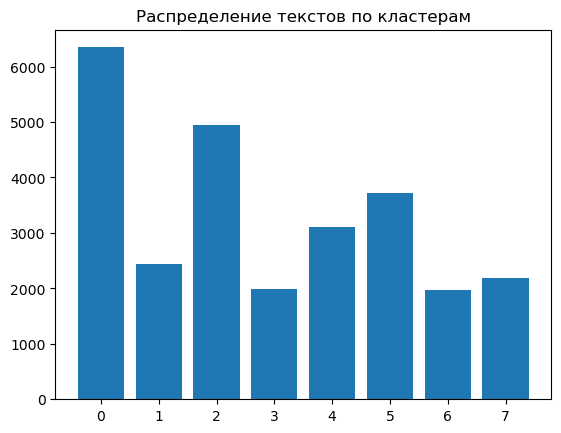

In [48]:
plt.bar(cluster_counts.keys(), cluster_counts.values())
plt.title('Распределение текстов по кластерам')

In [49]:
score = silhouette_score(w2v_text_embeddings, clusters)
print('Итоговое значение Silhouette Score:', score)

Итоговое значение Silhouette Score: 0.35007387


Дополнительно визуализируем полученные кластеры с помощью t-SNE. Так как текстов очень много, возьмем случайные 2000 для визуализации.

In [50]:
from sklearn.manifold import TSNE

n = 2000
idxs = np.random.choice(range(len(w2v_text_embeddings)), n)
data_2d = TSNE(
    n_components=2, learning_rate='auto',
    init='random', perplexity=3
).fit_transform(w2v_text_embeddings[idxs])
data_2d.shape

(2000, 2)

Text(0.5, 1.0, 'Визуализация кластеров с помощью t-SNE')

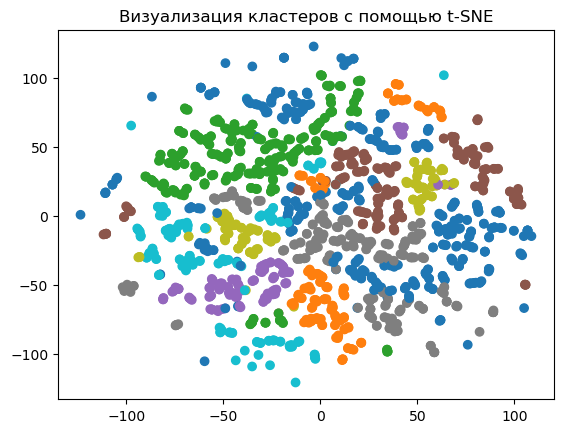

In [51]:
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=clusters[idxs], cmap='tab10')
plt.title('Визуализация кластеров с помощью t-SNE')

Распределение объектов получилось довольно адекватным, как и значение Silhouette Score и вид t-SNE. Значит, все в порядке, можно смотреть на сами кластеры.

## Анализ кластеров

Для анализа кластеров посмотрим на несколько текстов, лежащих наиболее близко к центрам. Именно эти тексты будут лучше всего описывать кластер.

__Задание 10.__ Напишите функцию `find_nearest`, которая принимает эмбеддинг текста `embedding`, матрицу эмбеддингов других текстов `text_embeddings`, а также параметр `k`. Функция возвращает __индексы__ текстов из `text_embeddings`, которые лежат ближе всего в `embedding` с точки зрения косинусного расстояния. Для подсчета косинусной близости можно использовать функцию `cosine_similarity` из `sklearn`. Учтите, что она принимает на вход две __матрицы__. Поэтому эмбеддинг текста необходимо будет дополнить одной размерностью.

In [52]:
from sklearn.metrics.pairwise import cosine_similarity

In [53]:
def find_nearest(embedding, text_embeddings, k=10):
    embedding = embedding.reshape(1, -1)  # Преобразуем вектора в матрицу (1, N)
    
    similarities = cosine_similarity(embedding, text_embeddings)
    
    nearest_idxs = similarities.argsort()[0][-k:][::-1]  # Сортируем по убыванию и берем k лучших

    return nearest_idxs


In [54]:
for i, center in enumerate(kmeans.cluster_centers_):
    nearest_idxs = find_nearest(center, w2v_text_embeddings, k=10)
    nearest_texts = list(data.text[nearest_idxs])
    print(f'Topic № {i}')
    for text in nearest_texts:
        print(text)
    print()

Topic № 0
i have to see the ETA of purchase {{Order Number}} cn uhelp me
I'd liketo see the ETA of the purchase {{Order Number}} help me
can uhelp me seethe ETA of order {{Order Number}}
nee to locate purchase {{Order Number}} help me
want assistance to switch several items of purchase {{Order Number}}
could uhelp me see the eta of purchase {{Order Number}}
can uhelp me see the ETA of purchase {{Order Number}}
could uhelp me checkingb the eta of the purchase {{Order Number}}
ihave to locate purchase {{Order Number}} help me
wat help to see the ETA of purchase {{Order Number}}

Topic № 1
need assitance setting my new delivery address up
need assistance entering my new shipping address
i need help setting up my new delivery address
I want assistance entering my new shipping address
I need assistance submitting the new shipping address
I want assistance entering the new delivery address
I want help setting a new shipping address up
i want help setting up a new shipping address
want help s

Видим, что тексты в разных кластерах действительно отличаются по темам обращений. Однако, так оценивать темы довольно сложно. Лучше визуализируем кластеры с помощью облаков слов. Они будут показывать, какие слова встречаются чаще других в каждом кластере.

In [57]:
# !pip install wordcloud

In [58]:
from wordcloud import WordCloud

In [59]:
def create_lda_wordcloud(texts):
    wordcloud = WordCloud(
        width=1600, height=800, max_words=200, background_color='white', collocations=False
    ).generate(' '.join(texts))
    plt.figure(figsize=(7, 5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

Topic № 0


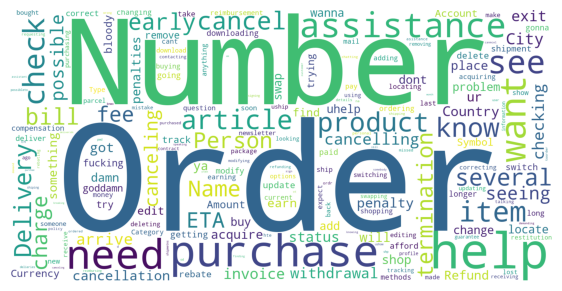

Topic № 1


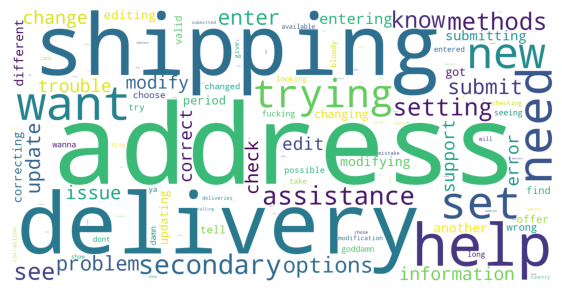

Topic № 2


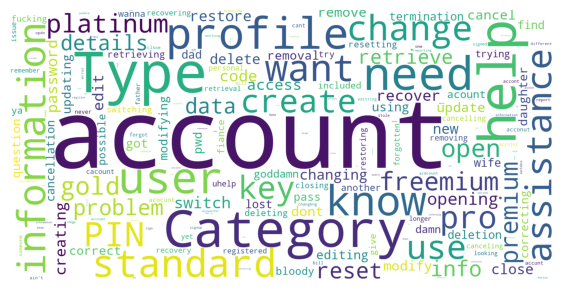

Topic № 3


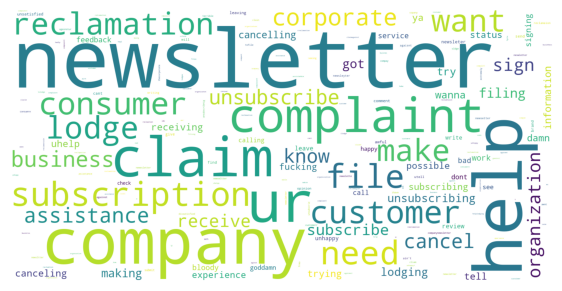

Topic № 4


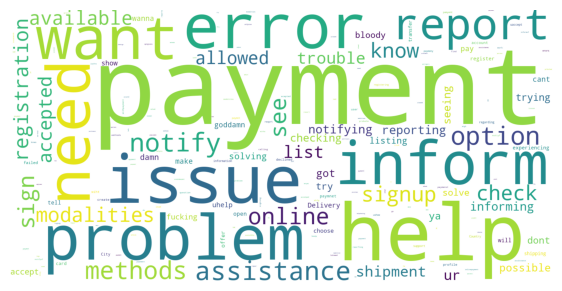

Topic № 5


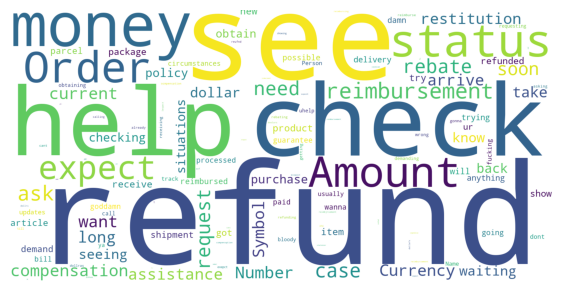

Topic № 6


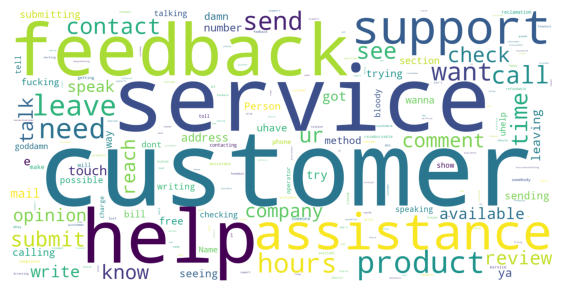

Topic № 7


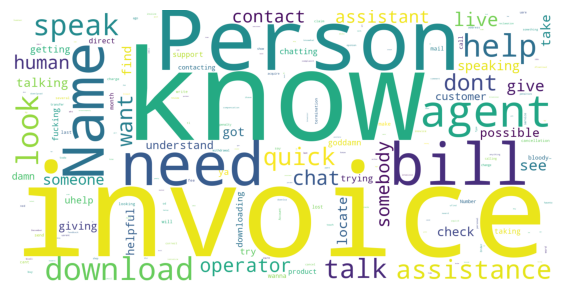

In [60]:
for i in range(best_k):
    mask = (clusters == i)
    cluster_texts = data.text[mask]
    print(f'Topic № {i}')
    create_lda_wordcloud(cluster_texts)

Из облаков разница между кластерами видна гораздо лучше. Теперь можем брать их вместе с результатами распределения обращений по кластерам и нести в технический отдел, чтобы они чинили ту часть сервиса, на которую жалуются больше всего. По пути назад зайдем в HR отдел за повышением :)